<a href="https://colab.research.google.com/github/Dioriza/Tensorflow-Project/blob/master/Time_Series_Prediction_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional


%matplotlib inline
sns.set(style='whitegrid', palette='muted')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Get Data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"muhammaddioriza","key":"9659fcadd4165a4b3a9c1a4820340a31"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle competitions download -c MTIDACmincompW1

test.csv: Skipping, found more recently modified local copy (use --force to force download)
data%20dict.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
local_zip = '/content/train.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Import Dataset & EDA

Data dari pembangunan area di kota X. merupakan data yang disajikan dalam bentuk *hourly dataset* atau per jam yang memiliki 35000 jumlah baris dan memiliki data awal pada tahun 2010 hingga akhir tahun 2013. Data original memiliki kolom terpisah antara tahun, bulan, hari, dan jam. Pada proses data selection, kita akan menyatukan kolom ini kedalam satu kolom dengan format datetime.

Yang mana awalnya adalah **'year',	'month',	'day',	'hour'** menjadi **'datetime'**.

Yang terakhir adalah kita akan membuat model forecasting dengan LSTM pada target kolom adalah Temperatur dengan format data adalah derajat celcius.



In [ ]:
data_train = pd.read_csv('/tmp/train.csv',)
data_train.head()

,id,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [ ]:
# Data selection
data_train['datetime'] = pd.to_datetime(data_train[['year', 'month','day', 'hour']])
data_train = data_train.drop(['year', 'month','day', 'hour'], axis = 1)
data_train = data_train[['datetime', 'DEWP', 'TEMP', 'PRES', 'cbwd']].iloc[24:].reset_index()
data_train.index = data_train.datetime
data_train = data_train.drop(columns=['datetime', 'cbwd', 'index', 'DEWP', 'PRES'])
data_train.head()

,TEMP
datetime,
2010-01-02 00:00:00,-4.0
2010-01-02 01:00:00,-4.0
2010-01-02 02:00:00,-5.0
2010-01-02 03:00:00,-5.0
2010-01-02 04:00:00,-5.0


In [ ]:
# Check ukuran
data_train.shape

(35040, 1)

In [ ]:
# check missing value
data_train.isnull().sum()

TEMP    0
dtype: int64

In [ ]:
# Check minimun dan maximum value pada data
print(data_train.min())
print(data_train.max())

TEMP   -19.0
dtype: float64
TEMP    41.0
dtype: float64


In [ ]:
MAE_SCORE = (data_train.max() - data_train.min()) * 10/100
print('Target MAE Score dari skala data < ', MAE_SCORE)

Target MAE Score dari skala data <  TEMP    6.0
dtype: float64


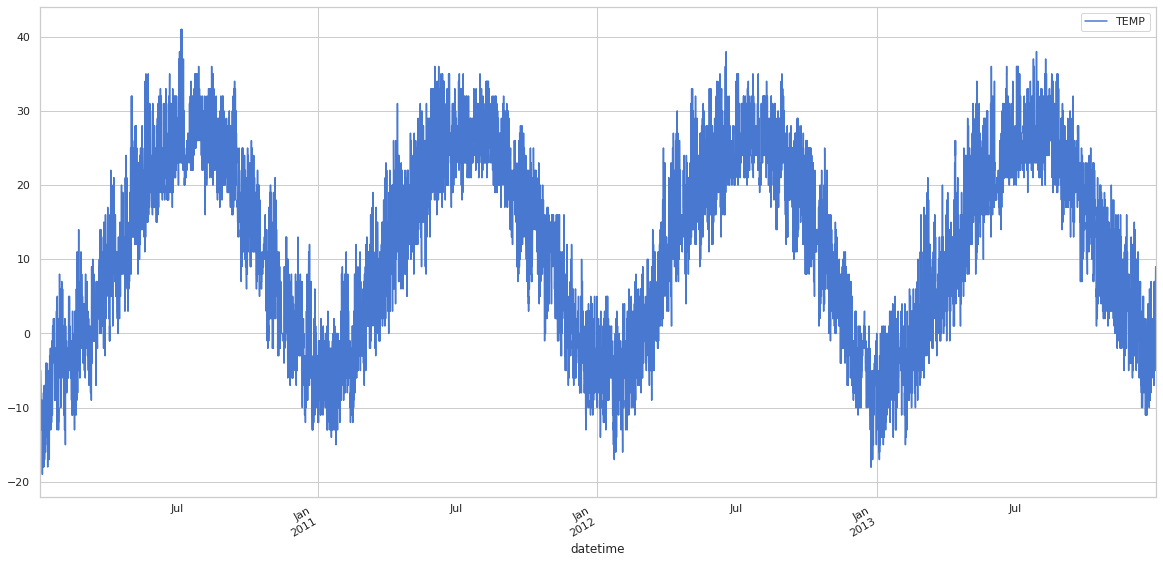

In [ ]:
#Plot data
plot_cols = data_train.columns
plot_features = data_train[plot_cols]
plot_features.index = data_train.index
_ = plot_features.plot(subplots=True, figsize=(20,10))

In [ ]:
data_train[1:25]

,TEMP
datetime,
2010-01-02 01:00:00,-4.0
2010-01-02 02:00:00,-5.0
2010-01-02 03:00:00,-5.0
2010-01-02 04:00:00,-5.0
2010-01-02 05:00:00,-6.0
2010-01-02 06:00:00,-6.0
2010-01-02 07:00:00,-5.0
2010-01-02 08:00:00,-6.0
2010-01-02 09:00:00,-5.0


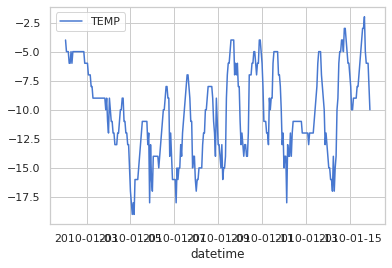

In [ ]:
#Plot data per dalam 2 minggu pertama
sns.lineplot(data=data_train[1:335])

In [ ]:
#Data Normalisasi atau Scaling data
train_mean = data_train[:300000].mean()
train_std = data_train[:300000].std()
data = (data_train-train_mean)/train_std
data

,TEMP
datetime,
2010-01-02 00:00:00,-1.312575
2010-01-02 01:00:00,-1.312575
2010-01-02 02:00:00,-1.393830
2010-01-02 03:00:00,-1.393830
2010-01-02 04:00:00,-1.393830
...,...
2013-12-31 19:00:00,-0.418778
2013-12-31 20:00:00,-0.418778
2013-12-31 21:00:00,-0.418778


# Train Test Split & Data Format

N = Jumlah baris
F = Feature
S = Sequence/ Window


Pada input data SVM, Random Forest, Naive Bayes dll.. memiliki input data [N,F] Jika pada gambar dibawah ini data ini memiliki ukuran [15, 2].

Untuk input data RNN yang mana ini adalah bentuk dari data kita, ukuran datanya akan dirubah dengan format [N, S, F] maka pada data dibawah ini format ukuran datanya akan menjadi [5, 3, 2] artinya memiliki 5 Data, 3 Sequence atau window dan memiliki 1 fitur.

Pada dataset kali ini kita akan memformat [N, S, F] menjadi per minggu data dari awal data training [28032, 1] dirubah dengan format sequence atau window dengan 7 hari dikali satu hari data. 

![alt text](https://1.bp.blogspot.com/-E3udgc7glRw/X0moIlqZRTI/AAAAAAAAB74/1GIf8yJ2U-InHsXvDliTJ27R3NL6c5aMwCLcBGAsYHQ/w945-h600-p-k-no-nu/Screen%2BShot%2B2020-08-29%2Bat%2B7.57.48%2Bam.png)

In [ ]:
# Split data 80% untuk training dan 20% untuk test
train_data = int(len(data) * 0.8)
test_data = len(data) - train_data
train, test = data.iloc[0:train_data], data.iloc[train_data:len(data)]
print(train.shape, test.shape)

(28032, 1) (7008, 1)


In [ ]:
# Window function untuk reshape ke 3D data
def create_sequences(X_train, y_train,time_steps=1):
    Xs,ys =[],[]
    for i in range(len(X_train)-time_steps):
        Xs.append(X_train.iloc[i:(i+time_steps)].values)
        ys.append(y_train.iloc[i+time_steps])
        
    return np.array(Xs),np.array(ys)

In [ ]:
#Memfilter data train dan test dengan 1 minggu data = 168, 24 row = 1 hari
time_steps=24*7

X_train,y_train = create_sequences(train[['TEMP']],train.TEMP,time_steps)
X_test,y_test = create_sequences(test[['TEMP']],train.TEMP,time_steps)
print(X_train.shape,y_train.shape, X_test.shape,y_test.shape)

(27864, 168, 1) (27864,) (6840, 168, 1) (6840,)


# LSTM Bidirectional Layer

Cara kerja dari LSTM Bidirectional adalah menjalankan input dua arah kedalam dua cara, satu dari masa lalu ke masa depan dan satu dari masa depan ke masa lalu dan apa yang berbeda dari pendekatan ini adalah berbeda dengan Unidirectional LSTM yang berjalan mundur saat menyimpan informasi dari masa depan dan menggunakan dua *hidden state* digabungkan pada suatu pada suatu titik waktu untuk menyimpan informasi dari masa lalu dan masa depan.

Dipilih karena peforma penurunan cost atau loss lebih baik ketimbang forward lstm dan backward lstm.

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Line-Plot-of-Log-Loss-for-an-LSTM-Reversed-LSTM-and-a-Bidirectional-LSTM.png)

## Training Model & Testing

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(168, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM),
    optimizer=tf.keras.optimizers.Adam(lr=1e-4),
    metrics=["mae"]
)

callback = tf.keras.callbacks.EarlyStopping(monitor='mae',patience=3)

history = model.fit(
        X_train, y_train, epochs=100,batch_size=64, callbacks=[callback]
)

Epoch 1/100
436/436 [==============================] - 19s 44ms/step - loss: 4.6632 - mae: 0.2945
Epoch 2/100
436/436 [==============================] - 19s 44ms/step - loss: 1.8106 - mae: 0.1860
Epoch 3/100
436/436 [==============================] - 20s 46ms/step - loss: 1.4585 - mae: 0.1670
Epoch 4/100
436/436 [==============================] - 20s 47ms/step - loss: 1.3010 - mae: 0.1570
Epoch 5/100
436/436 [==============================] - 21s 48ms/step - loss: 1.2153 - mae: 0.1506
Epoch 6/100
436/436 [==============================] - 21s 48ms/step - loss: 1.1121 - mae: 0.1448
Epoch 7/100
436/436 [==============================] - 21s 47ms/step - loss: 1.0500 - mae: 0.1404
Epoch 8/100
436/436 [==============================] - 21s 47ms/step - loss: 1.0069 - mae: 0.1371
Epoch 9/100
436/436 [==============================] - 21s 48ms/step - loss: 0.9591 - mae: 0.1338
Epoch 10/100
436/436 [==============================] - 21s 48ms/step - loss: 0.9389 - mae: 0.1321
Epoch 11/100
436/43

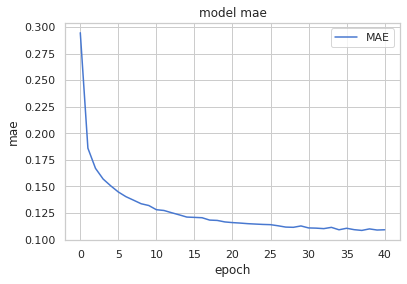

In [ ]:
# Plotting mae loss
plt.plot(history.history['mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

214/214 [==============================] - 3s 15ms/step - loss: 19.6538 - mae: 1.0540


[19.65384292602539, 1.054032564163208]

## Model kita telah memiliki nilai MAE yang bagus pada data test yaitu 1.05 dengan skala < 6

In [ ]:
X_plot = model.predict(X_train, verbose=0)

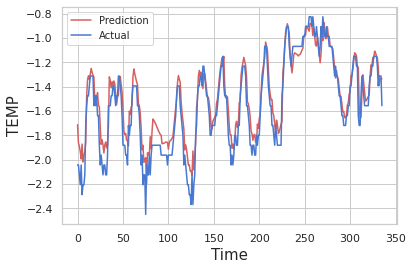

In [ ]:
#Plot Preds vs Actual
aa=[x for x in range(336)]
plt.plot(aa, X_plot[:336], 'r',  label="Prediction")
plt.plot(aa, y_train[:336], 'b', label="Actual")
plt.ylabel('TEMP', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=10)
plt.show()

# Update Window Dataset

In [ ]:
# Window/sequence yang dipilih menkadi per 3 hari data.
time_step=24*3

X_train,y_train = create_sequences(train[['TEMP']],train.TEMP,time_step)
X_test,y_test = create_sequences(test[['TEMP']],train.TEMP,time_step)
print(X_train.shape,y_train.shape, X_test.shape,y_test.shape)


(27960, 72, 1) (27960,) (6936, 72, 1) (6936,)


Epoch 1/100
437/437 [==============================] - 9s 21ms/step - loss: 4.6494 - mae: 0.2927
Epoch 2/100
437/437 [==============================] - 9s 21ms/step - loss: 1.8689 - mae: 0.1887
Epoch 3/100
437/437 [==============================] - 9s 21ms/step - loss: 1.5244 - mae: 0.1696
Epoch 4/100
437/437 [==============================] - 9s 21ms/step - loss: 1.3476 - mae: 0.1599
Epoch 5/100
437/437 [==============================] - 9s 21ms/step - loss: 1.2157 - mae: 0.1511
Epoch 6/100
437/437 [==============================] - 9s 21ms/step - loss: 1.1315 - mae: 0.1459
Epoch 7/100
437/437 [==============================] - 9s 21ms/step - loss: 1.0561 - mae: 0.1404
Epoch 8/100
437/437 [==============================] - 9s 21ms/step - loss: 1.0154 - mae: 0.1375
Epoch 9/100
437/437 [==============================] - 9s 21ms/step - loss: 0.9746 - mae: 0.1346
Epoch 10/100
437/437 [==============================] - 9s 21ms/step - loss: 0.9342 - mae: 0.1317
Epoch 11/100
437/437 [=======

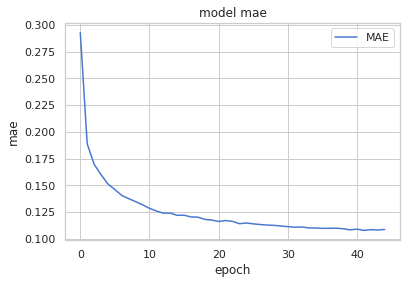

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(168, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM),
    optimizer=tf.keras.optimizers.Adam(lr=1e-4),
    metrics=["mae"]
)

callback = tf.keras.callbacks.EarlyStopping(monitor='mae',patience=3)

history = model.fit(
        X_train, y_train, epochs=100,batch_size=64, callbacks=[callback]
)

# Plotting mae loss
plt.plot(history.history['mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

217/217 [==============================] - 2s 7ms/step - loss: 19.6817 - mae: 1.0533


[19.681652069091797, 1.053336501121521]

Model kita telah memiliki nilai MAE yang bagus pada data test yaitu 1.05. dengan skala < 6

In [ ]:
X_plot = model.predict(X_train, verbose=0)

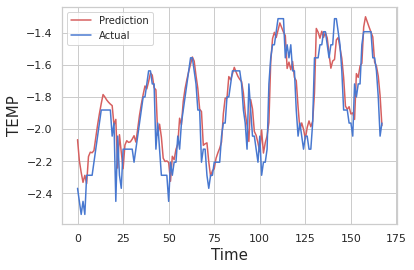

In [ ]:
#Plot Preds vs Actual
aa=[x for x in range(168)]
plt.plot(aa, X_plot[:168], 'r',  label="Prediction")
plt.plot(aa, y_train[:168], 'b', label="Actual")
plt.ylabel('TEMP', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=10)
plt.show()

# Referensi

- https://www.dicoding.com/academies/185
- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.youtube.com/watch?v=ZtVwUM_V1Zo&list=PLGn1wRmlR3Ms0f5m56nTh0Jr-nZ6Rv7NU&index=10
- https://medium.com/@llmkhoa511/time-series-analysis-and-weather-forecast-in-python-e80b664c7f71
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://youtu.be/H4J74KstHTE
- https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/